## Scene Recognition using Bag of Visual Words (BOVW)

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from os import listdir
import os
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
trainPath='../dataset/SUN_data/SUN_data/train/'
testPath='../dataset/SUN_data/SUN_data/test/'

#Get image paths
def getImagePaths(tPath):
    imagePath=[]
    for directory in listdir(tPath):
        joinedPath=os.path.join(tPath,directory)
        if(os.path.isdir(joinedPath)):
            for file in listdir(joinedPath):
                imagePath.append(os.path.join(joinedPath,file))
    return imagePath

def addLabel(path, img_labels):
    if("aquarium" in path):
        img_labels.append("aquarium")
    elif("desert" in path):
        img_labels.append("desert")
    elif("highway" in path):
        img_labels.append("highway")
    elif("kitchen" in path):
        img_labels.append("kitchen")
    elif("laundromat" in path):
        img_labels.append("laundromat")
    elif("park" in path):
        img_labels.append("park")
    elif("waterfall" in path):
        img_labels.append("waterfall")
    elif("windmill" in path):
        img_labels.append("windmill")

def getDescriptors(imagePath, stepSize):
    sift = cv.SIFT_create()
    descriptors=np.empty((0,128), dtype=float)
    desList=[]
    imgPathList=[]
    img_labels=[]
    for path in imagePath:
        img=cv.imread(path)
        try:
            img=cv.resize(img,(150,150))
            kp=[]
            for row in range(0, np.shape(img)[0], stepSize):
                for col in range(0, np.shape(img)[1], stepSize):
                    kp.append(cv.KeyPoint(col, row, stepSize))
            des = sift.compute(img, kp)[1]
#             _, des = sift.detectAndCompute(img,None)
            descriptors=np.append(descriptors, des, axis=0)
            desList.append(des)
            addLabel(path, img_labels)
            imgPathList.append(path)
        except:
            pass

    desList=np.array(desList, dtype='object')
#     print(len(imgPathList))
#     print(np.shape(descriptors))
#     print(np.shape(desList))    
    return desList, descriptors, imgPathList, img_labels

def computeHist(numImages, numClusters, desList, km):
#     numImages=len(imgPathList)
    img_words=np.zeros((numImages, numClusters), dtype=int)
    for img in range(numImages):
        for feature in desList[img]:
            cluster=km.predict(feature.reshape(1,-1).astype('float64'))
            img_words[img][cluster]+=1
#     print(np.shape(img_words))
#     print(img_words)
#     print(np.sum(img_words))
    return img_words

def computeTFIDF(img_words, isTest, idf=0):

    tf=np.zeros(np.shape(img_words))
    for row in range(np.shape(img_words)[0]):
        tf[row]=img_words[row]/np.sum(img_words[row])

    if(isTest==False):
        N=np.shape(img_words)[0]
        idf=np.zeros(np.shape(img_words)[1])
        for col in range(np.shape(img_words)[1]):
            occurences=len(np.where(img_words[:,col]!=0)[0])
            idf[col]=np.log(N/occurences)

    img_words2=np.zeros(np.shape(img_words))
    for col in range(np.shape(img_words2)[1]):
        img_words2[:,col]=tf[:,col]*idf[col]
        
    return img_words2, idf


def getOptimalC(img_words, img_labels):
    CList=[3,2,1,0.5]
    scoreList=[]
    for c in CList:
        svm=SVC(C=c, kernel='linear')
        score=cross_val_score(svm, img_words, img_labels, cv=5)
        score=np.sum(score)/5
        scoreList.append(score)

    optimalC=CList[np.argmax(scoreList)]
    return optimalC

def dispOutput(img_labels, pred_label, imgPathList):
    idx=np.where(img_labels==pred_label)[0]
    randomIdx = random.sample(range(0, len(idx)-1), 6)
    randomIdx=idx[randomIdx]
    plt.figure(figsize=(20, 10))
    for count,i in enumerate(randomIdx):
        img=cv.imread(imgPathList[i])
        plt.subplot(2,3,count+1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(f'Original Label: {img_labels[i]}\nPredicted Label: {pred_label[i]}')
    plt.show()

    idx=np.where(img_labels!=pred_label)[0]
    randomIdx = random.sample(range(0, len(idx)-1), 6)
    randomIdx=idx[randomIdx]
    plt.figure(figsize=(20, 10))
    for count,i in enumerate(randomIdx):
        img=cv.imread(imgPathList[i])
        plt.subplot(2,3,count+1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(f'Original Label: {img_labels[i]}\nPredicted Label: {pred_label[i]}')
    plt.show()


In [3]:
def BOVW(trainPath, testPath, numClusters, stepSize):
    #get descriptors and labels from train images
    imagePath=getImagePaths(trainPath)
    desList, descriptors, imgPathList, img_labels = getDescriptors(imagePath, stepSize)
    img_labels=np.array(img_labels)
    numImages=len(imgPathList)
    print("Descriptors for train images computed")
    
    #form clusters and compute Histogram
    km=KMeans(n_clusters=numClusters).fit(descriptors)
    img_words=computeHist(numImages, numClusters, desList, km)
    img_words, idf=computeTFIDF(img_words, False)
    print("Histogram computed")
    
    #Find optimal C for SVM
    optimalC=getOptimalC(img_words,img_labels)
    print("Optimal C: ", optimalC)
    
    #Train SVM for optimal C
    svm=SVC(C=optimalC, kernel='linear').fit(img_words,img_labels)
    print("SVM Trained")
    
    #get descriptors and labels from test images
    imagePath=getImagePaths(testPath)
    desList, _, imgPathList, img_labels = getDescriptors(imagePath, stepSize)
    img_labels=np.array(img_labels)
    numImages=len(imgPathList)
    print("Descriptors for test images computed")
    
    #find words in different clusters for each image
    img_words=computeHist(numImages, numClusters, desList, km)
    print("Histogram for test images computed")

    #Compute TF only and use IDF from training data to compute TF-IDF
    img_words, _ = computeTFIDF(img_words, True, idf)
    pred_label=svm.predict(img_words)
    
    score=confusion_matrix(img_labels, pred_label)
    print(f"Confusion Matrix: \n{score}")
    score=accuracy_score(img_labels, pred_label)
    print(f"Accuracy Score: {score}")
    return score, img_labels, pred_label, imgPathList

Running for 300 clusters...
Descriptors for train images computed
Histogram computed
Optimal C:  1
SVM Trained
Descriptors for test images computed
Histogram for test images computed
Confusion Matrix: 
[[13  1  1  1  1  1  2  0]
 [ 1 13  2  1  0  0  1  2]
 [ 0  6 12  0  0  1  0  1]
 [ 1  1  1 14  3  0  0  0]
 [ 1  0  0  2 16  0  1  0]
 [ 1  0  0  1  0 17  0  1]
 [ 7  1  0  0  1  5  6  0]
 [ 1  4  2  0  0  1  0 12]]
Accuracy Score: 0.64375



Running for 450 clusters...
Descriptors for train images computed
Histogram computed
Optimal C:  3
SVM Trained
Descriptors for test images computed
Histogram for test images computed
Confusion Matrix: 
[[11  1  1  1  1  1  2  2]
 [ 2 11  3  0  1  1  0  2]
 [ 0  4 15  0  1  0  0  0]
 [ 2  1  0 15  1  0  1  0]
 [ 0  0  1  2 17  0  0  0]
 [ 1  0  0  0  0 18  0  1]
 [ 4  1  0  2  1  4  7  1]
 [ 1  3  0  0  0  0  0 16]]
Accuracy Score: 0.6875



Running for 600 clusters...
Descriptors for train images computed
Histogram computed
Optimal C:  2
SVM Traine

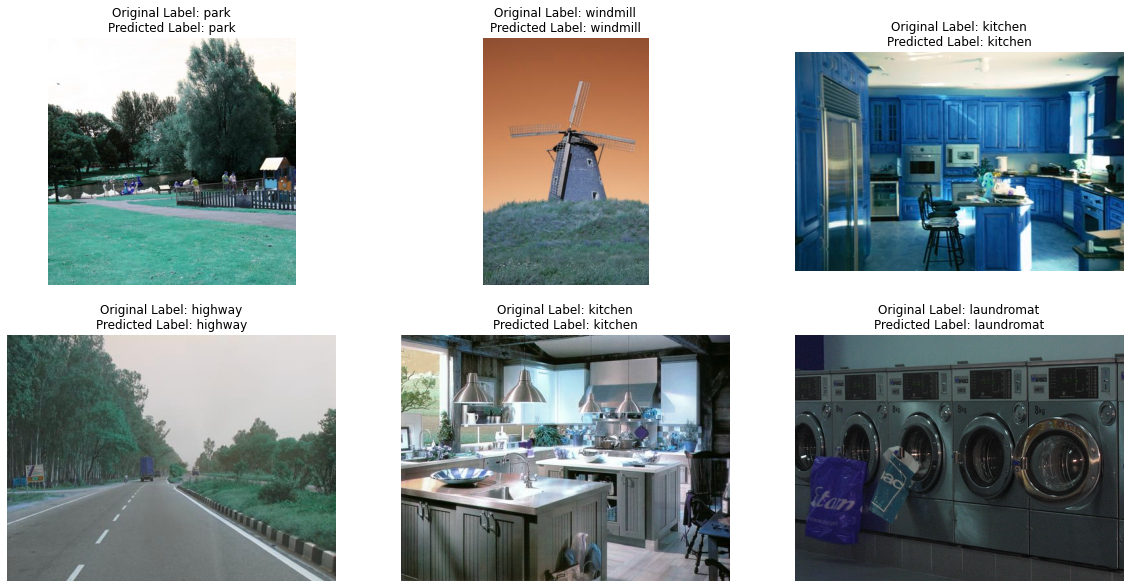

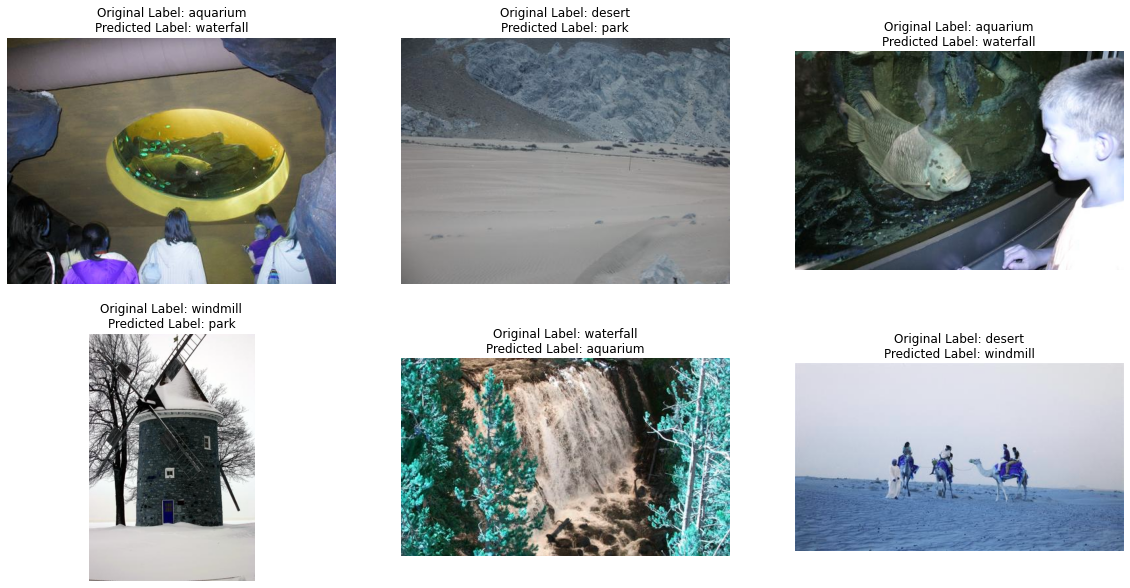

In [4]:
numClusters=[300,450,600,750,900]
maxScore=0
optimalTrueLabels=[]
optimalPredLabels=[]
optimalImgPath=[]
optimalClusters=0
for num in numClusters:
    print(f"Running for {num} clusters...")
    score, img_labels, pred_label, imgPathList = BOVW(trainPath, testPath, num, 10)
    if(score>maxScore):
        optimalTrueLabels=img_labels
        optimalPredLabels=pred_label
        optimalImgPath=imgPathList
        maxScore=score
        optimalClusters=num
    print("\n\n")

print(f"Optimal Clusters: {optimalClusters}")
dispOutput(optimalTrueLabels, optimalPredLabels, optimalImgPath)

Running for 150 clusters...
Descriptors for train images computed
Histogram computed
Optimal C:  3
SVM Trained
Descriptors for test images computed
Histogram for test images computed
Confusion Matrix: 
[[12  1  1  1  2  1  2  0]
 [ 0  8  5  1  1  2  0  3]
 [ 0  3 16  0  0  0  1  0]
 [ 2  0  2 10  4  1  0  1]
 [ 1  0  0  5 11  1  1  1]
 [ 2  0  0  1  1 15  0  1]
 [ 9  1  0  1  0  5  4  0]
 [ 2  2  1  0  1  2  0 12]]
Accuracy Score: 0.55



Running for 300 clusters...
Descriptors for train images computed
Histogram computed
Optimal C:  3
SVM Trained
Descriptors for test images computed
Histogram for test images computed
Confusion Matrix: 
[[10  1  1  0  3  3  2  0]
 [ 0 11  3  1  1  3  0  1]
 [ 0  5 15  0  0  0  0  0]
 [ 1  0  1 13  4  0  1  0]
 [ 1  0  0  3 16  0  0  0]
 [ 2  0  1  0  1 15  0  1]
 [ 5  1  0  0  2  7  5  0]
 [ 2  2  2  0  1  1  0 12]]
Accuracy Score: 0.60625



Running for 450 clusters...
Descriptors for train images computed
Histogram computed
Optimal C:  3
SVM Trained


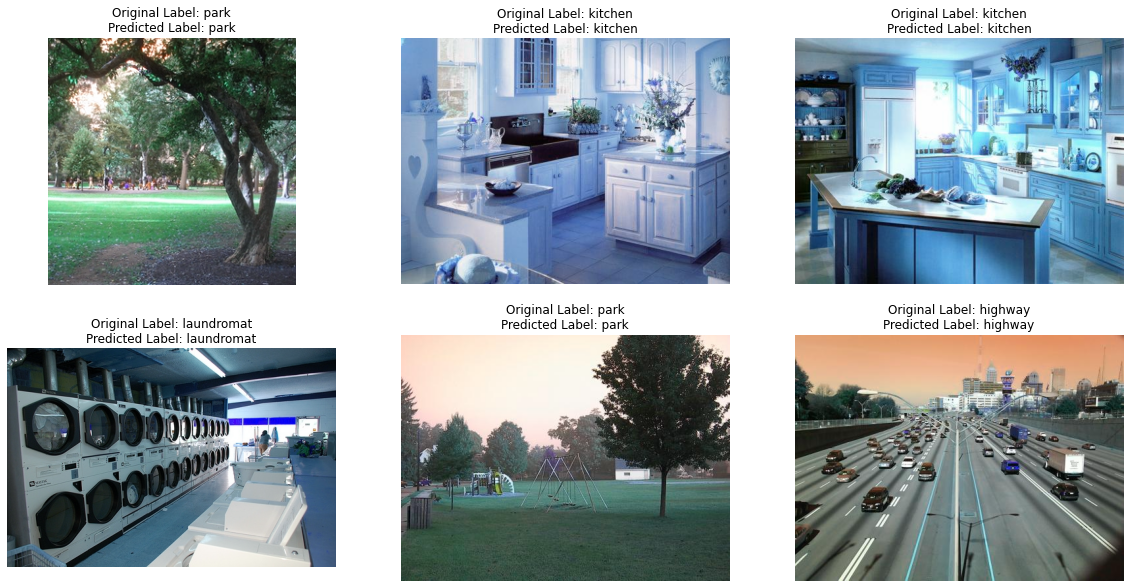

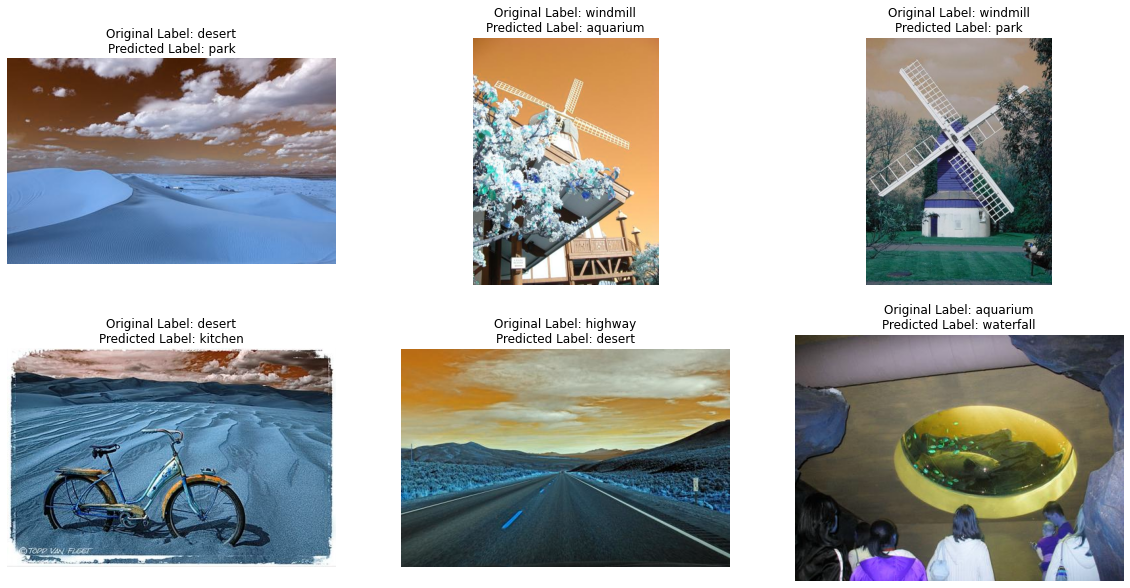

In [4]:
numClusters=[150,300,450]
maxScore=0
optimalTrueLabels=[]
optimalPredLabels=[]
optimalImgPath=[]
optimalClusters=0
for num in numClusters:
    print(f"Running for {num} clusters...")
    score, img_labels, pred_label, imgPathList = BOVW(trainPath, testPath, num, 15)
    if(score>maxScore):
        optimalTrueLabels=img_labels
        optimalPredLabels=pred_label
        optimalImgPath=imgPathList
        maxScore=score
        optimalClusters=num
    print("\n\n")

print(f"Optimal Clusters: {optimalClusters}")
dispOutput(optimalTrueLabels, optimalPredLabels, optimalImgPath)